In [1]:
import numpy as np
import os
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as data
from PIL import Image
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle
import math
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet101

def smooth(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def predict(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

class I2D(nn.Module):
    def __init__(self, pretrained=True):
        super(I2D, self).__init__()

        resnet = resnet101(pretrained=pretrained)

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = nn.Sequential(resnet.layer1) # 256
        self.layer2 = nn.Sequential(resnet.layer2) # 512
        self.layer3 = nn.Sequential(resnet.layer3) # 1024
        self.layer4 = nn.Sequential(resnet.layer4) # 2048

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 256, 256, kernel_size=1, stride=1, padding=0)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        # Depth prediction
        self.predict1 = smooth(256, 64)
        self.predict2 = predict(64, 1)
        
    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        _,_,H,W = x.size() # batchsize N,channel,height,width
        
        # Bottom-up
        c1 = self.layer0(x) 
        c2 = self.layer1(c1) # 256 channels, 1/4 size
        c3 = self.layer2(c2) # 512 channels, 1/8 size
        c4 = self.layer3(c3) # 1024 channels, 1/16 size
        c5 = self.layer4(c4) # 2048 channels, 1/32 size

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4)) # 256 channels, 1/16 size
        p4 = self.smooth1(p4) 
        p3 = self._upsample_add(p4, self.latlayer2(c3)) # 256 channels, 1/8 size
        p3 = self.smooth2(p3) # 256 channels, 1/8 size
        p2 = self._upsample_add(p3, self.latlayer3(c2)) # 256, 1/4 size
        p2 = self.smooth3(p2) # 256 channels, 1/4 size

        return self.predict2( self.predict1(p2) )     # depth; 1/4 size, mode = "L"

class NYUv2Dataset(data.Dataset):
    def __init__(self):
        self.name_map = pickle.load(open("./nyuv2/index.pkl",'rb'))
        self.rgb_paths = list(self.name_map.keys())
        self.rgb_transform = Compose([ToTensor()])
        self.depth_transform = Compose([ToTensor()])
        self.length = len(self.rgb_paths)
            
    def __getitem__(self, index):
        path = './nyuv2/test_rgb/'+self.rgb_paths[index]
        rgb = Image.open(path)
        depth = Image.open('./nyuv2/test_depth/'+self.name_map[self.rgb_paths[index]])
#         depth.save("gt_origin.ppm")
        depth = depth.resize((160,120))
        return self.rgb_transform(rgb).float(), self.depth_transform(depth).float()

    def __len__(self):
        return self.length

In [2]:
if __name__ == '__main__':
    # dataset
    LOAD_DIR = '.'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    eval_dataset = NYUv2Dataset()
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1,shuffle=True)
    i2d = I2D().to(DEVICE)
    i2d.load_state_dict(torch.load('{}/fyn_model.pt'.format(LOAD_DIR),map_location='cpu'))
    print("model loaded")
    # setting to eval mode
    i2d.eval()
    print('evaluating...')
    with torch.no_grad():
        for i,(data,gt) in enumerate(eval_dataloader):
            data,gt = data.to(DEVICE),gt.to(DEVICE)
            pred_depth = i2d(data)
            rgb_img = transforms.ToPILImage()(data.squeeze(0))
            rgb_resize = rgb_img.resize((160,120))
            gt_img = transforms.ToPILImage()(gt.int().squeeze(0))
#             gt_img.save("gt.ppm")
            depth_img = transforms.ToPILImage()(pred_depth.int().squeeze(0))
#             depth_img.save("pred.ppm")
            break

model loaded
evaluating...


c:\users\ethan\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
c:\users\ethan\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


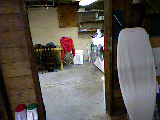

In [3]:
rgb_resize

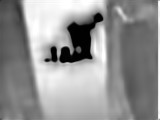

In [4]:
depth_img

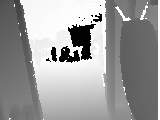

In [5]:
gt_img

In [20]:
i2d

I2D(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0)

## Test PyTorch: Loading Image ToTensor

https://blog.csdn.net/Turbo_Come/article/details/99705169

original image from PIL: [WxH] = 640x480
Type: <PIL.PpmImagePlugin.PpmImageFile image mode=I size=640x480 at 0x2658D5140B8>
tensor([[[46595., 46851., 46851.,  ..., 65287., 65287., 65287.],
         [46595., 46595., 46851.,  ..., 65287., 65287., 65287.],
         [46595., 46851., 47107.,  ..., 65287., 65287., 65287.],
         ...,
         [65287., 65287., 19715.,  ..., 65287., 65287., 65287.],
         [19971., 19715., 19715.,  ..., 65287., 65287., 65287.],
         [19715., 19715., 19715.,  ..., 65287., 65287., 65287.]]])
convert Image to Tensor: [Channel,Height,Width] = 1x480x640
Type of the image tensor: <class 'torch.Tensor'>
Image recovered from tensor: (640, 480)
Type: <PIL.Image.Image image mode=I size=640x480 at 0x2658D514198>


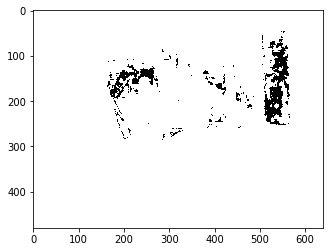

In [19]:
import os
from PIL import Image
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
from torchvision import transforms
import torch
import random
import matplotlib.pyplot as plt

test_rgb_list = os.listdir("./nyuv2/test_depth")
file = random.choice(test_rgb_list)
img = Image.open("./nyuv2/test_depth/{}".format(file))
W,H = img.size
print("original image from PIL: [WxH] = {}x{}".format(W,H))
print("Type: {}".format(img))
# convert PIL Image to tensor
img_tensor = Compose([ToTensor()])(img).float()
Ch,H,W = img_tensor.shape
print(img_tensor)
print("convert Image to Tensor: [Channel,Height,Width] = {}x{}x{}".format(Ch,H,W))
print("Type of the image tensor: {}".format(type(img_tensor)))
# convert tensor to PIL Image
recon_img = transforms.ToPILImage()(img_tensor.int().squeeze(0))
print("Image recovered from tensor: {}".format(recon_img.size))
print("Type: {}".format(recon_img))
plt.imshow(img,cmap='gray')
# img.save("1.ppm")

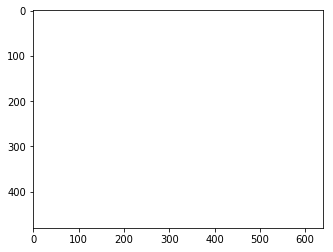

In [56]:
plt.imshow(recon_img,cmap='gray')
recon_img.save("2.ppm")